In [1]:
!pip install librosa numpy tensorflow scikit-learn matplotlib seaborn shap lime scikit-image  --quiet

In [2]:
!pip install tensorflow numpy librosa scikit-learn --quiet

In [3]:
import os
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

2025-08-11 07:07:48.159892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754896068.504800      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754896068.606985      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Configuration parameters
SAMPLE_RATE = 16000 # Common sample rate for audio processing
N_FFT = 1024        # Number of samples per FFT window
HOP_LENGTH = 512    # Number of samples between successive frames
N_MELS = 128        # Number of Mel bands to generate
MAX_AUDIO_LEN_SECONDS = 3 # Max duration for audio segments (e.g., 3 seconds)

In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
base_data_dir = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds'

# Lists to store file paths and labels
audio_files = []
labels = [] # 0 for real, 1 for fake

# Define the subdirectories containing the audio data
splits = ['training', 'validation', 'testing']
audio_types = ['real', 'fake']

print(f"Starting data loading from: {base_data_dir}")

for split in splits:
    for audio_type in audio_types:
        current_dir = os.path.join(base_data_dir, split, audio_type)
        if os.path.exists(current_dir):
            count = 0
            for filename in os.listdir(current_dir):
                if filename.endswith('.wav'): # Assuming .wav files
                    audio_files.append(os.path.join(current_dir, filename))
                    labels.append(1 if audio_type == 'fake' else 0)
                    count += 1
            print(f"Found {count} '{audio_type}' audio files in '{split}' split.")
        else:
            print(f"Directory not found: {current_dir}")

# Convert to numpy arrays
audio_files = np.array(audio_files)
labels = np.array(labels)

# Shuffle the data (important as data is loaded sequentially by type/split)
indices = np.arange(len(audio_files))
np.random.shuffle(indices)
audio_files = audio_files[indices]
labels = labels[indices]

print(f"Total audio files loaded: {len(audio_files)}")
print(f"Total labels loaded: {len(labels)}")


Starting data loading from: /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds
Found 6978 'real' audio files in 'training' split.
Found 6978 'fake' audio files in 'training' split.
Found 1413 'real' audio files in 'validation' split.
Found 1413 'fake' audio files in 'validation' split.
Found 544 'real' audio files in 'testing' split.
Found 544 'fake' audio files in 'testing' split.
Total audio files loaded: 17870
Total labels loaded: 17870


In [7]:
def preprocess_audio(file_path, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS):
    """
    Loads, resamples, and normalizes an audio file.
    Pads or truncates audio to a fixed length.
    """
    try:
        y, sr = librosa.load(file_path, sr=target_sr)

        # Normalize audio volume (optional but recommended)
        y = librosa.util.normalize(y)

        # Pad or truncate audio to a fixed length
        target_length = int(target_sr * max_len_seconds)
        if len(y) > target_length:
            y = y[:target_length] # Truncate
        elif len(y) < target_length:
            # Pad with zeros
            padding = np.zeros(target_length - len(y))
            y = np.concatenate((y, padding))

        return y
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [8]:
preprocessed_example = preprocess_audio(audio_files[0])
if preprocessed_example is not None:
    print(f"Example preprocessed audio shape: {preprocessed_example.shape}")

Example preprocessed audio shape: (48000,)


In [9]:
def extract_features(audio_waveform, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Extracts Mel-spectrogram from an audio waveform.
    """
    if audio_waveform is None:
        return None

    # Compute Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (decibels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return np.expand_dims(mel_spectrogram_db, axis=-1)

# Apply preprocessing and feature extraction to all audio files
features = []
processed_labels = [] # Keep track of labels for successfully processed files

print("Starting feature extraction. This may take a while...")
for i, file_path in enumerate(audio_files):
    audio_waveform = preprocess_audio(file_path)
    if audio_waveform is not None:
        feature = extract_features(audio_waveform)
        if feature is not None:
            features.append(feature)
            processed_labels.append(labels[i])
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1}/{len(audio_files)} files.")

features = np.array(features)
processed_labels = np.array(processed_labels)

print(f"Feature extraction complete. Total features: {features.shape}")
print(f"Total labels after processing: {processed_labels.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    features, processed_labels, test_size=0.2, random_state=42, stratify=processed_labels
)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Starting feature extraction. This may take a while...
Processed 100/17870 files.
Processed 200/17870 files.
Processed 300/17870 files.
Processed 400/17870 files.
Processed 500/17870 files.
Processed 600/17870 files.
Processed 700/17870 files.
Processed 800/17870 files.
Processed 900/17870 files.
Processed 1000/17870 files.
Processed 1100/17870 files.
Processed 1200/17870 files.
Processed 1300/17870 files.
Processed 1400/17870 files.
Processed 1500/17870 files.
Processed 1600/17870 files.
Processed 1700/17870 files.
Processed 1800/17870 files.
Processed 1900/17870 files.
Processed 2000/17870 files.
Processed 2100/17870 files.
Processed 2200/17870 files.
Processed 2300/17870 files.
Processed 2400/17870 files.
Processed 2500/17870 files.
Processed 2600/17870 files.
Processed 2700/17870 files.
Processed 2800/17870 files.
Processed 2900/17870 files.
Processed 3000/17870 files.
Processed 3100/17870 files.
Processed 3200/17870 files.
Processed 3300/17870 files.
Processed 3400/17870 files.
Pro

In [10]:
def augment_spectrogram(spectrogram):
    """
    Applies simple augmentation to a spectrogram.
    For demonstration, this is a placeholder. Real augmentation is more complex.
    """
    augmented_spec = np.copy(spectrogram)
    # Example: Simple noise addition (conceptual)
    # noise_factor = 0.01 * np.random.rand()
    # augmented_spec += noise_factor * np.random.randn(*spectrogram.shape)
    return augmented_spec
print("Data augmentation step outlined. Implement specific augmentation techniques as needed.")

Data augmentation step outlined. Implement specific augmentation techniques as needed.


In [11]:
input_shape = X_train[0].shape
print(f"CNN Input Shape: {input_shape}")

model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same',
           kernel_regularizer=regularizers.l2(0.001)), # Added L2 regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3), # Increased dropout

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)), # Added L2 regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3), # Increased dropout

    # Third Convolutional Block (optional, for deeper networks)
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)), # Added L2 regularization
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.4), # Increased dropout

    # Flatten the output for the Dense layers
    Flatten(),

    # Fully Connected Layers
    Dense(256, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)), # Added L2 regularization
    BatchNormalization(),
    Dropout(0.6), # Increased dropout significantly for dense layers

    # Output Layer for binary classification (Real/Fake)
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

model.summary()


CNN Input Shape: (128, 94, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754896420.245765      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754896420.246436      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 94, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 94, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,291,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,386,561 (24.36 MB)

 Trainable params: 6,385,601 (24.36 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.001), # Adam optimizer with a learning rate
    loss='binary_crossentropy',          # Binary cross-entropy for 2 classes
    metrics=['accuracy']                 # Track accuracy during training
)

print("Model compiled successfully.")

Model compiled successfully.


Starting model training for up to 50 epochs with batch size 32...
Best model will be saved to: best_deepfake_detector_model.h5
EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint callbacks are active.
Epoch 1/50


I0000 00:00:1754896428.563743     120 service.cc:148] XLA service 0x7ccfa00091f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754896428.565081     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754896428.565100     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754896429.175477     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/403 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6671 - loss: 1.4469   

I0000 00:00:1754896435.900327     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


403/403 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8496 - loss: 1.0374
Epoch 1: val_loss improved from inf to 2.99280, saving model to best_deepfake_detector_model.h5
403/403 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.8497 - loss: 1.0368 - val_accuracy: 0.5098 - val_loss: 2.9928 - learning_rate: 0.0010
Epoch 2/50
401/403 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9752 - loss: 0.4471
Epoch 2: val_loss improved from 2.99280 to 1.09671, saving model to best_deepfake_detector_model.h5
403/403 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9753 - loss: 0.4467 - val_accuracy: 0.7231 - val_loss: 1.0967 - learning_rate: 0.0010
Epoch 3/50
400/403 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9849 - loss: 0.3225
Epoch 3: val_loss did not improve from 1.09671
403/403 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9849 - loss: 0.3224 - val_accuracy: 0.6762 - val_loss: 1.3790 - learning_rate: 0.0010
Epoch 4/50
401/403 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9838 - loss: 

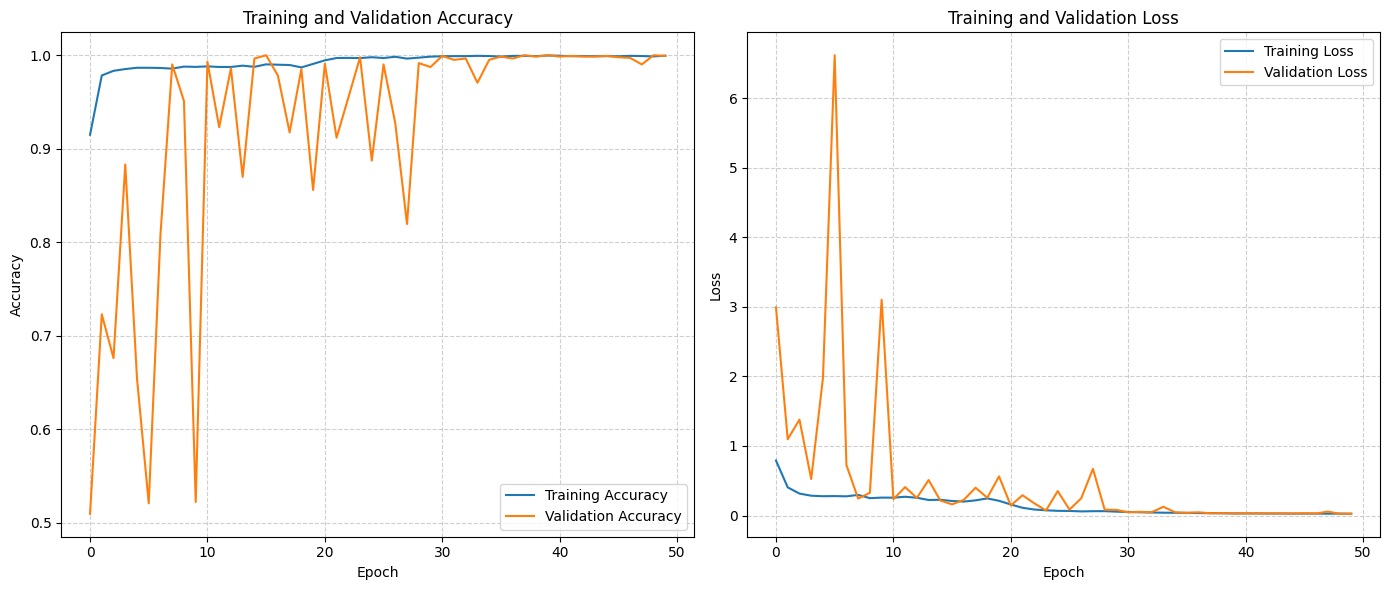

In [13]:
EPOCHS = 50 # Increased max epochs, EarlyStopping will manage actual epochs
BATCH_SIZE = 32

# Define callbacks for better training control
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=7,          # Increased patience to allow more room for improvement
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss
    factor=0.2,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=4,         # Increased patience before reducing LR
    min_lr=0.00001,     # Lower bound on the learning rate.
    verbose=1
)

# Define ModelCheckpoint to save the best model
model_save_path = 'best_deepfake_detector_model.h5' # .h5 for HDF5 format
checkpoint = ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_loss', # Monitor validation loss
    save_best_only=True, # Save only the best model
    mode='min',          # 'min' because we want to minimize validation loss
    verbose=1
)

print(f"Starting model training for up to {EPOCHS} epochs with batch size {BATCH_SIZE}...")
print(f"Best model will be saved to: {model_save_path}")
print("EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint callbacks are active.")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1, # Use 10% of training data for validation
    callbacks=[early_stopping, reduce_lr, checkpoint], # Add checkpoint here
    verbose=1
)

print("Model training complete.")

# Plot training history
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Evaluating model performance on the test set...
Test Loss: 0.0265
Test Accuracy: 0.9992
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Precision: 0.9983
Recall: 1.0000
F1-Score: 0.9992
Confusion Matrix:
[[1784    3]
 [   0 1787]]


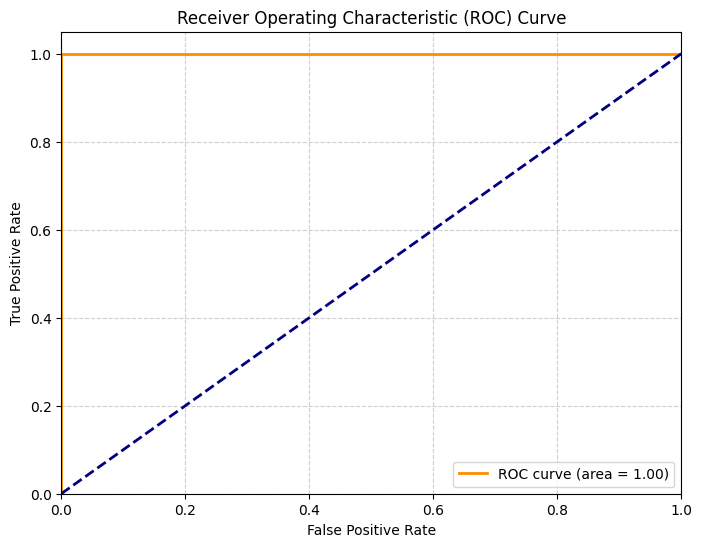

In [14]:
print("Evaluating model performance on the test set...")

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Interpretation of Confusion Matrix:
# [[True Negatives (TN), False Positives (FP)]
#  [False Negatives (FN), True Positives (TP)]]
# TN: Real audio correctly classified as Real
# FP: Real audio incorrectly classified as Fake
# FN: Fake audio incorrectly classified as Real
# TP: Fake audio correctly classified as Fake


--- Testing with a presumed REAL audio file ---

--- Processing new audio file: /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real/file10.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
Prediction Probability (Fake): 0.0000
Classification: REAL

--- Testing with a presumed FAKE audio file ---

--- Processing new audio file: /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake/file100.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction Probability (Fake): 1.0000
Classification: FAKE

Inference function defined. Use it with your trained model and new audio files.

--- Visualizing Prediction Pipeline for: /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake/file100.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction Probability (Fake): 1.0000
Classification: FAKE


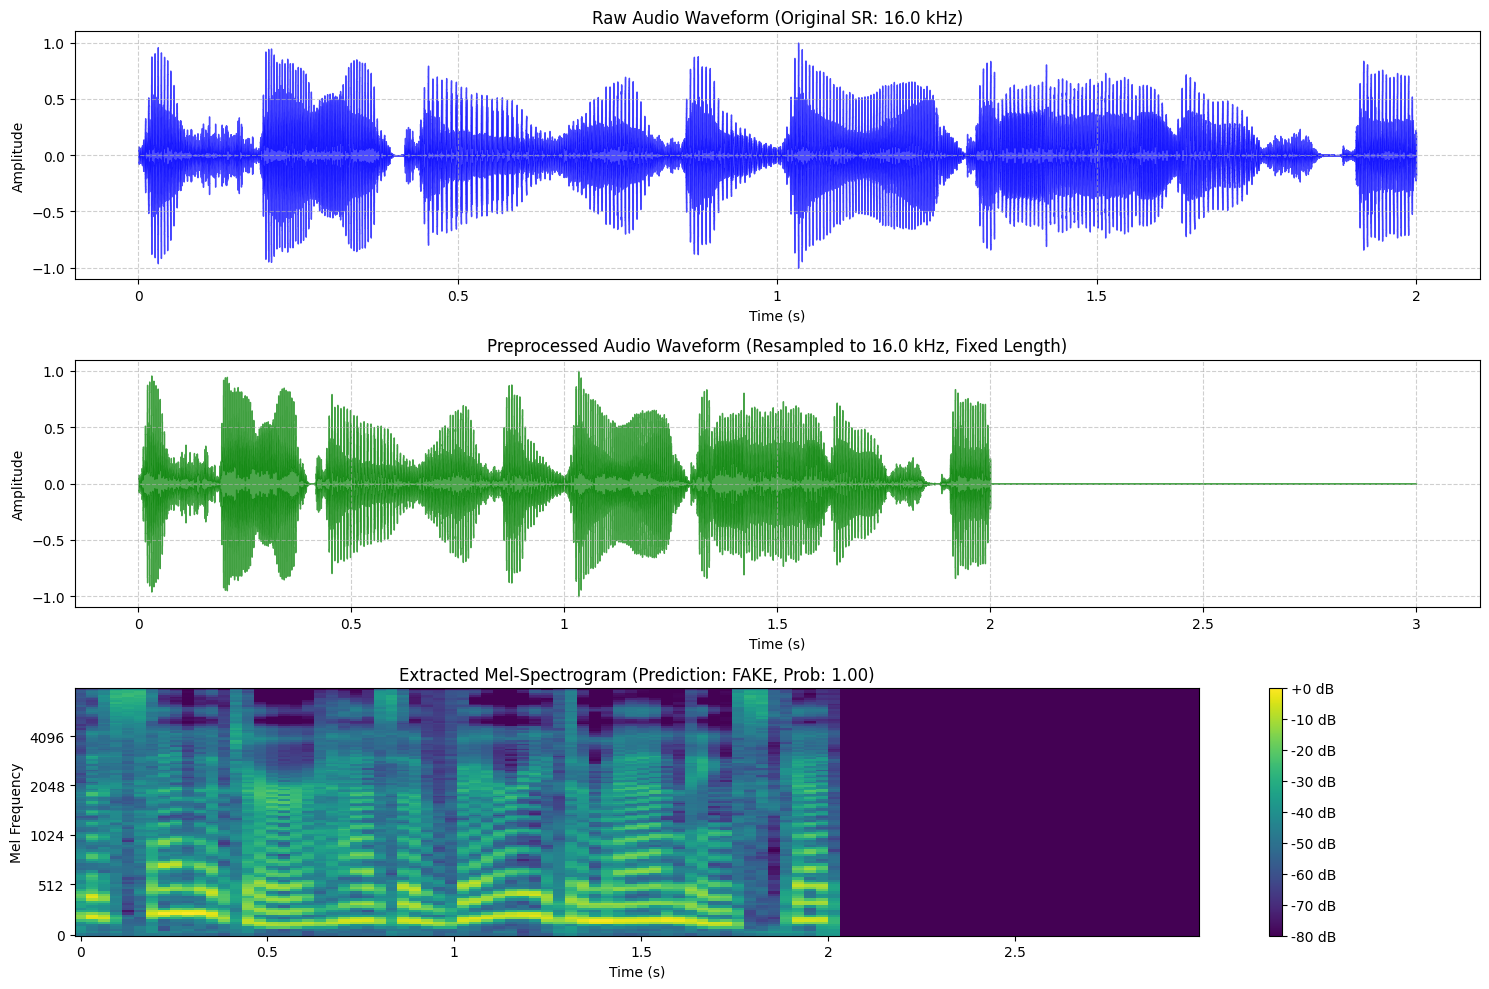

In [16]:
import numpy as np
import librosa
import librosa.display # Needed for visualization functions like waveshow and specshow
import tensorflow as tf
import matplotlib.pyplot as plt # Needed for plotting
# Assuming 'model' is loaded externally, e.g., model = tf.keras.models.load_model('your_model_path.h5')
# from tensorflow.keras.models import load_model # Uncomment if you want to load model inside this script

# --- Configuration Parameters (These must match what was used during training) ---
SAMPLE_RATE = 16000 # Common sample rate for audio processing
N_FFT = 1024        # Number of samples per FFT window
HOP_LENGTH = 512    # Number of samples between successive frames
N_MELS = 128        # Number of Mel bands to generate
MAX_AUDIO_LEN_SECONDS = 3 # Max duration for audio segments (e.g., 3 seconds)

# --- Preprocessing Function (Required by predict_deepfake and visualize_prediction_pipeline) ---
def preprocess_audio(file_path, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS):
    """
    Loads, resamples, and transforms an audio file for model input.
    Pads or truncates audio to a fixed length and normalizes volume.
    """
    try:
        y, sr = librosa.load(file_path, sr=target_sr)

        # Normalize audio volume (optional but recommended)
        y = librosa.util.normalize(y)

        # Pad or truncate audio to a fixed length
        target_length = int(target_sr * max_len_seconds)
        if len(y) > target_length:
            y = y[:target_length] # Truncate
        elif len(y) < target_length:
            # Pad with zeros
            padding = np.zeros(target_length - len(y))
            y = np.concatenate((y, padding))

        return y
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- Feature Extraction Function (Required by predict_deepfake and visualize_prediction_pipeline) ---
def extract_features(audio_waveform, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Extracts Mel-spectrogram from an audio waveform.
    """
    if audio_waveform is None:
        return None

    # Compute Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (decibels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Expand dimensions for CNN input (height, width, channels)
    # For a single channel (mono audio), channels=1
    return np.expand_dims(mel_spectrogram_db, axis=-1)

# --- The predict_deepfake function ---
def predict_deepfake(audio_file_path, model, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS,
                     n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Predicts whether an audio file is real or fake using the trained model.
    """
    print(f"\n--- Processing new audio file: {audio_file_path} ---")

    # 1. Preprocess audio
    audio_waveform = preprocess_audio(audio_file_path, target_sr, max_len_seconds)
    if audio_waveform is None:
        return "Error: Could not preprocess audio."

    # 2. Extract features
    features = extract_features(audio_waveform, target_sr, n_fft, hop_length, n_mels)
    if features is None:
        return "Error: Could not extract features."

    # Model expects a batch of inputs, so add batch dimension
    features = np.expand_dims(features, axis=0)

    # 3. Make prediction
    prediction_proba = model.predict(features)[0][0] # Get the single probability

    # 4. Classify based on threshold
    if prediction_proba > 0.5:
        result = "FAKE"
    else:
        result = "REAL"

    print(f"Prediction Probability (Fake): {prediction_proba:.4f}")
    print(f"Classification: {result}")
    return result

# --- End-to-End Pipeline for Visualization ---
def visualize_prediction_pipeline(audio_file_path, model, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS,
                                  n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Predicts whether an audio file is real or fake using the trained model,
    and visualizes the preprocessing and feature extraction steps.
    """
    print(f"\n--- Visualizing Prediction Pipeline for: {audio_file_path} ---")

    # 1. Load Raw Audio (with original sample rate for accurate display)
    raw_y, raw_sr = librosa.load(audio_file_path, sr=None)

    # 2. Preprocess Audio
    preprocessed_y = preprocess_audio(audio_file_path, target_sr, max_len_seconds)
    if preprocessed_y is None:
        print("Error: Could not preprocess audio for visualization.")
        return

    # 3. Extract Features (Mel-Spectrogram)
    features = extract_features(preprocessed_y, target_sr, n_fft, hop_length, n_mels)
    if features is None:
        print("Error: Could not extract features for visualization.")
        return

    # Model expects a batch of inputs, so add batch dimension for prediction
    features_for_prediction = np.expand_dims(features, axis=0)

    # 4. Make Prediction
    prediction_proba = model.predict(features_for_prediction)[0][0]
    classification_result = "FAKE" if prediction_proba > 0.5 else "REAL"

    print(f"Prediction Probability (Fake): {prediction_proba:.4f}")
    print(f"Classification: {classification_result}")

    # 5. Visualize the Process
    plt.figure(figsize=(15, 10))

    # Plot 1: Raw Waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(raw_y, sr=raw_sr, color='blue', alpha=0.7)
    plt.title(f'Raw Audio Waveform (Original SR: {raw_sr/1000:.1f} kHz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Preprocessed Waveform
    plt.subplot(3, 1, 2)
    librosa.display.waveshow(preprocessed_y, sr=target_sr, color='green', alpha=0.7)
    plt.title(f'Preprocessed Audio Waveform (Resampled to {target_sr/1000:.1f} kHz, Fixed Length)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot 3: Mel-Spectrogram
    plt.subplot(3, 1, 3)
    librosa.display.specshow(features[:, :, 0], sr=target_sr, x_axis='time', y_axis='mel',
                             cmap='viridis', hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Extracted Mel-Spectrogram (Prediction: {classification_result}, Prob: {prediction_proba:.2f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()



test_audio_path_real = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/real/file10.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav'
test_audio_path_fake = '/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/testing/fake/file100.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav'

print("\n--- Testing with a presumed REAL audio file ---")
predict_deepfake(test_audio_path_real, model)

print("\n--- Testing with a presumed FAKE audio file ---")
predict_deepfake(test_audio_path_fake, model)

print("\nInference function defined. Use it with your trained model and new audio files.")

# print("\n--- Visualizing the pipeline for a FAKE audio file ---")
visualize_prediction_pipeline(test_audio_path_fake, model)


In [17]:
!pip install lime shap

Model loaded successfully!

--- Running LIME Explanation for a REAL audio file (file29993.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav) ---

--- Running LIME Explanation for: /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real/file29993.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav ---


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

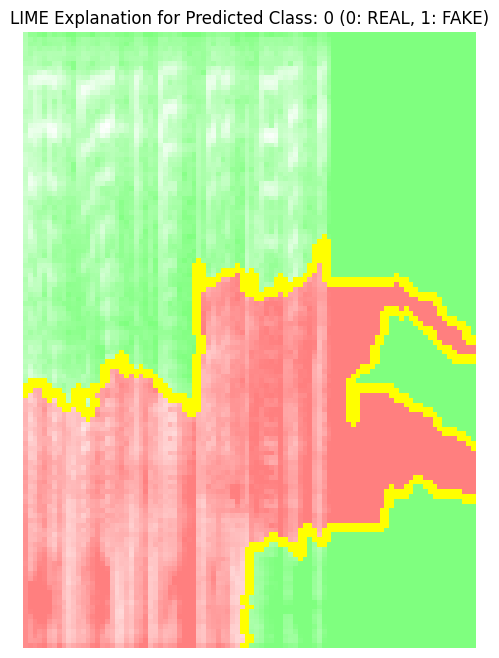

LIME explanation generated.

--- Running LIME Explanation for a FAKE audio file (file12881.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav) ---

--- Running LIME Explanation for: /kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/fake/file12881.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav ---


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

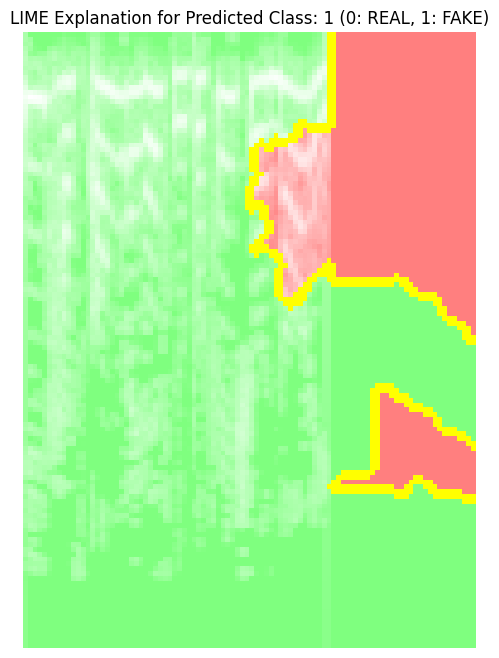

LIME explanation generated.


In [18]:
import numpy as np
import librosa
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
# cv2 is no longer needed without Grad-CAM
import os # Import os for path manipulation

# --- XAI Specific Imports ---
from lime import lime_image # For LIME
from skimage.segmentation import mark_boundaries # For LIME visualization
# shap is removed

# --- Configuration Parameters (These must match what was used during training) ---
# These parameters are already defined in your notebook, but included here for completeness
SAMPLE_RATE = 16000 # Common sample rate for audio processing
N_FFT = 1024        # Number of samples per FFT window
HOP_LENGTH = 512    # Number of samples between successive frames
N_MELS = 128        # Number of Mel bands to generate
MAX_AUDIO_LEN_SECONDS = 3 # Max duration for audio segments (e.g., 3 seconds)

# --- Preprocessing Function (Copied from your notebook for self-containment) ---
def preprocess_audio(file_path, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS):
    """
    Loads, resamples, and transforms an audio file for model input.
    Pads or truncates audio to a fixed length and normalizes volume.
    """
    try:
        y, sr = librosa.load(file_path, sr=target_sr)

        # Normalize audio volume (optional but recommended)
        y = librosa.util.normalize(y)

        # Pad or truncate audio to a fixed length
        target_length = int(target_sr * max_len_seconds)
        if len(y) > target_length:
            y = y[:target_length] # Truncate
        elif len(y) < target_length:
            # Pad with zeros
            padding = np.zeros(target_length - len(y))
            y = np.concatenate((y, padding))

        return y
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- Feature Extraction Function (Copied from your notebook for self-containment) ---
def extract_features(audio_waveform, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Extracts Mel-spectrogram from an audio waveform.
    """
    if audio_waveform is None:
        return None

    # Compute Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_waveform,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (decibels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Expand dimensions for CNN input (height, width, channels)
    # For a single channel (mono audio), channels=1
    return np.expand_dims(mel_spectrogram_db, axis=-1)

# --- The predict_deepfake function (unchanged) ---
def predict_deepfake(audio_file_path, model, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS,
                     n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    """
    Predicts whether an audio file is real or fake using the trained model.
    """
    print(f"\n--- Processing new audio file: {audio_file_path} ---")

    # 1. Preprocess audio
    audio_waveform = preprocess_audio(audio_file_path, target_sr, max_len_seconds)
    if audio_waveform is None:
        return "Error: Could not preprocess audio."

    # 2. Extract features
    features = extract_features(audio_waveform, target_sr, n_fft, hop_length, n_mels)
    if features is None:
        return "Error: Could not extract features."

    # Model expects a batch of inputs, so add batch dimension
    features = np.expand_dims(features, axis=0)

    # 3. Make Prediction
    prediction_proba = model.predict(features)[0][0] # Get the single probability

    # 4. Classify based on threshold
    if prediction_proba > 0.5:
        result = "FAKE"
    else:
        result = "REAL"

    print(f"Prediction Probability (Fake): {prediction_proba:.4f}")
    print(f"Classification: {result}")
    return result

# --- LIME Explanation Function ---
def run_lime_explanation(audio_file_path, model, target_sr=SAMPLE_RATE, max_len_seconds=MAX_AUDIO_LEN_SECONDS,
                         n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, num_features=100, num_samples=1000):
    """
    Generates and visualizes a LIME explanation for an audio file's prediction.
    """
    print(f"\n--- Running LIME Explanation for: {audio_file_path} ---")

    preprocessed_y = preprocess_audio(audio_file_path, target_sr, max_len_seconds)
    if preprocessed_y is None:
        print("Error: Could not preprocess audio for LIME.")
        return

    features = extract_features(preprocessed_y, target_sr, n_fft, hop_length, n_mels)
    if features is None:
        print("Error: Could not extract features for LIME.")
        return

    # LIME expects input in the range [0, 1] or [0, 255] for image data
    # Normalize features to 0-1 range for LIME
    img_for_lime = (features[:, :, 0] - features[:, :, 0].min()) / (features[:, :, 0].max() - features[:, :, 0].min())
    img_for_lime = np.stack([img_for_lime, img_for_lime, img_for_lime], axis=-1) # LIME expects 3 channels

    # Define a prediction function for LIME
    # LIME needs a function that takes a batch of images and returns probabilities for each class.
    # Our model outputs a single probability for the 'fake' class.
    # We need to convert this to (prob_real, prob_fake)
    def lime_predict_fn(images):
        # images will be (N, H, W, 3), convert back to (N, H, W, 1) and scale back to original range
        images_mono = images[:, :, :, 0:1] # Take one channel

        # Rescale from [0,1] back to original spectrogram range for model input
        # This is a simplification; ideally, you'd use the min/max from your training data
        min_val = features[:, :, 0].min()
        max_val = features[:, :, 0].max()
        images_scaled = images_mono * (max_val - min_val) + min_val

        # Ensure the model is built before prediction
        if not model.built:
            # Build with a dummy input. Use the input shape expected by the model.
            # Assuming the model expects (None, N_MELS, num_time_steps, 1)
            dummy_input_shape = (1, N_MELS, images_scaled.shape[2], 1)
            _ = model(tf.zeros(dummy_input_shape))

        predictions_fake_prob = model.predict(images_scaled)
        # Convert single fake probability to (prob_real, prob_fake)
        return np.hstack([1 - predictions_fake_prob, predictions_fake_prob])

    # Create LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Get explanation for the image
    # For binary classification, class_names can be ['REAL', 'FAKE']
    # top_labels=1 means explain the top predicted class.
    explanation = explainer.explain_instance(
        img_for_lime.astype(np.double), # LIME expects double
        lime_predict_fn,
        top_labels=1,
        hide_color=0, # Color for masked regions
        num_samples=num_samples # Number of perturbed samples to generate
    )

    # Get image and mask for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], # The label to explain (0 or 1)
        positive_only=False, # Show both positive and negative contributions
        num_features=num_features, # Number of superpixels to show
        hide_rest=False # Show the rest of the image
    )

    # Visualize LIME explanation
    plt.figure(figsize=(10, 8))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)) # Normalize for display
    plt.title(f"LIME Explanation for Predicted Class: {explanation.top_labels[0]} (0: REAL, 1: FAKE)")
    plt.axis('off')
    plt.show()
    print("LIME explanation generated.")

# --- Example Usage ---
# You need to load your trained model first.
# Assuming your model is saved as 'best_deepfake_detector_model.h5' in the same directory
# where your notebook is running, or specify the full path.
try:
    model = tf.keras.models.load_model('best_deepfake_detector_model.h5')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure 'best_deepfake_detector_model.h5' exists in the correct path.")
    model = None # Set model to None so subsequent calls don't fail

if model:
    # Find a real and a fake audio file from your loaded dataset (X_test, y_test)
    # Assuming audio_files and labels are available from your data loading step.
    test_audio_path_real = None
    test_audio_path_fake = None

    # Iterate through the original audio_files and labels to find one real and one fake example
    for i, file_path in enumerate(audio_files):
        if labels[i] == 0 and test_audio_path_real is None: # 0 for real
            test_audio_path_real = file_path
        elif labels[i] == 1 and test_audio_path_fake is None: # 1 for fake
            test_audio_path_fake = file_path

        if test_audio_path_real and test_audio_path_fake:
            break # Found both, exit loop

    if test_audio_path_real:
        print(f"\n--- Running LIME Explanation for a REAL audio file ({os.path.basename(test_audio_path_real)}) ---")
        run_lime_explanation(test_audio_path_real, model)

    else:
        print("\nCould not find a REAL audio file path from the loaded dataset for visualization.")

    if test_audio_path_fake:
        print(f"\n--- Running LIME Explanation for a FAKE audio file ({os.path.basename(test_audio_path_fake)}) ---")
        run_lime_explanation(test_audio_path_fake, model)

    else:
        print("\nCould not find a FAKE audio file path from the loaded dataset for visualization.")
